In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

##Loading Data

In [2]:
dataset,info = tfds.load('tf_flowers',with_info = True,as_supervised = True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteVKZVJZ',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
for i, example in enumerate(dataset['train']):
    image, label = example
    save_dir = 'tf.flower/train/{}'.format(class_names[label])
    os.makedirs(save_dir, exist_ok=True)

    file_path = save_dir + "/" + "{}_{}.jpg".format(class_names[label], i)
    tf.keras.preprocessing.image.save_img(file_path, image.numpy())


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from keras.callbacks import LearningRateScheduler

##Data Augmentation

In [7]:
datagen = ImageDataGenerator(rescale=1/255,validation_split = 0.2,
                             rotation_range = 10,width_shift_range = 0.1,height_shift_range = 0.1,
                             shear_range = 0.1,zoom_range = 0.1,horizontal_flip = True,vertical_flip = True)

train_gen = datagen.flow_from_directory('tf.flower/train',target_size = (224,224),batch_size = 4,class_mode = "categorical",subset = 'training')
val_gen = datagen.flow_from_directory('tf.flower/train',target_size = (224,224),batch_size = 4,class_mode = "categorical",subset = 'validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


##Creating Base Model

In [8]:
model = Sequential()

model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 216, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 108, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 108, 108, 64)      256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 108, 108, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 106, 106, 128)     7

In [ ]:
history = model.fit(train_gen,epochs = 8,validation_data = val_gen)

Epoch 1/8
735/735 [==============================] - 103s 128ms/step - loss: 36.9050 - accuracy: 0.2763 - val_loss: 2.1950 - val_accuracy: 0.3160
Epoch 2/8
735/735 [==============================] - 92s 125ms/step - loss: 1.5837 - accuracy: 0.2998 - val_loss: 2.2318 - val_accuracy: 0.3365
Epoch 3/8
735/735 [==============================] - 91s 123ms/step - loss: 1.5554 - accuracy: 0.3072 - val_loss: 1.9899 - val_accuracy: 0.2900
Epoch 4/8
735/735 [==============================] - 90s 122ms/step - loss: 1.5349 - accuracy: 0.3273 - val_loss: 3.7715 - val_accuracy: 0.3830
Epoch 5/8
735/735 [==============================] - 89s 121ms/step - loss: 1.6020 - accuracy: 0.2630 - val_loss: 2.2368 - val_accuracy: 0.3051
Epoch 6/8
735/735 [==============================] - 90s 123ms/step - loss: 1.6013 - accuracy: 0.2766 - val_loss: 1.6355 - val_accuracy: 0.2777
Epoch 7/8
735/735 [==============================] - 89s 120ms/step - loss: 1.5962 - accuracy: 0.2579 - val_loss: 4.0639 - val_accurac

##Transfer Learning

In [10]:
from tensorflow.keras.applications import VGG16
model_VGG16 = VGG16(input_shape = (224,224,3),include_top = False,weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
for layer in model_VGG16.layers:
  layer.trainable = False

model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
model = Sequential()
model.add(model_VGG16)
model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(5,activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [28]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 13:
        lr *= 0.1
    elif epoch > 6:
        lr *= 0.5
    return lr

learning_rate_scheduler = LearningRateScheduler(lr_schedule)

history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[learning_rate_scheduler])

Epoch 1/20
735/735 [==============================] - 54s 73ms/step - loss: 0.7313 - accuracy: 0.7081 - val_loss: 0.6456 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 2/20
735/735 [==============================] - 52s 71ms/step - loss: 0.7597 - accuracy: 0.6968 - val_loss: 0.7283 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 3/20
735/735 [==============================] - 53s 72ms/step - loss: 0.7341 - accuracy: 0.7159 - val_loss: 0.5979 - val_accuracy: 0.7921 - lr: 0.0010
Epoch 4/20
735/735 [==============================] - 53s 72ms/step - loss: 0.7409 - accuracy: 0.7121 - val_loss: 0.7024 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 5/20
735/735 [==============================] - 53s 72ms/step - loss: 0.7231 - accuracy: 0.7155 - val_loss: 0.6066 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 6/20
735/735 [==============================] - 52s 71ms/step - loss: 0.7126 - accuracy: 0.7200 - val_loss: 0.5821 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 7/20
735/735 [==============================] - 53s 

## Plotting the training loss and validation loss

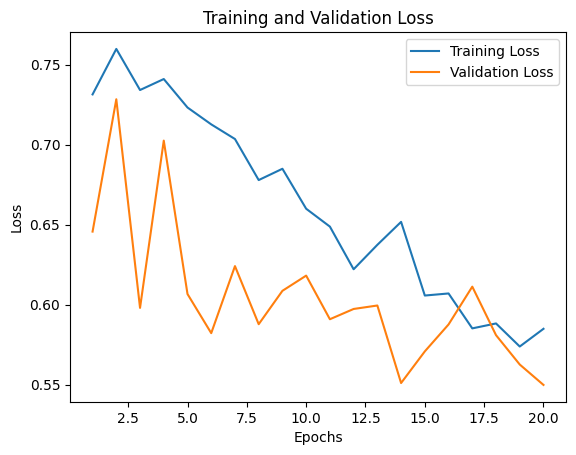

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
model.save('Flowers_classifier.h5')

## Prediction

In [31]:
import cv2 as cv

img = cv.imread('/content/tf.flower/train/tulips/tulips_1023.jpg')
img = cv.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])
img = img/255

In [32]:
pred = model.predict(img)

1/1 [==============================] - 0s 19ms/step


In [33]:
max_id = np.argmax(pred)
class_idx = {v:k for k,v in train_gen.class_indices.items()}
class_idx[max_id]

'roses'